In [1]:
import numpy as np
from Strategy import Player
import matplotlib.pyplot as plt

In [2]:
class Deck():
    def __init__(self,):
        self.cards = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']
        self.face_cards = ['J','Q','K']
    def draw(self,):
        card_drawn = np.random.choice(self.cards)
        return card_drawn

In [3]:
class BlackJack():
    def __init__(self, player):
        self.deck = Deck()
        self.hands_to_play = []
        self.dealer_public = None
        self.dealer_hidden = None
        self.bet = None
        self.hands_to_resolve = []
        self.player = player      
        self.bankrolls = []
    def deal(self, ):
        player_hand = [self.deck.draw(), self.deck.draw()]
        self.dealer_public = self.deck.draw()
        self.dealer_hidden = self.deck.draw()
        self.hands_to_play.append(player_hand)
        
    def reset(self, bet):
        self.bet = bet
        self.bets = [bet]
        self.player.bankroll -= self.bet
        self.deal()
        return (self.hands_to_play, self.hands_to_resolve, self.dealer_public)
    
    def hand_to_value(self, hand):
        value = 0
        aces = 0
        for card in hand:
            if card in self.deck.face_cards:
                value = value + 10
            elif card == 'A':
                value = value + 11
                aces = aces + 1
            else:
                value = value + int(card)
        while (value > 21 and aces > 0):
            value = value - 10
            aces = aces - 1
        return value
    
    
    def dealer_hit_strategy(self, dealer_hand):
        dealer_score = self.hand_to_value(dealer_hand)
        
        if(dealer_score < 17):
            dealer_hand.append(self.deck.draw())
            return self.dealer_hit_strategy(dealer_hand)

        elif(dealer_score in range(17, 22)):
            return dealer_score, self.check_blackjack(dealer_hand), dealer_hand

        elif(dealer_score > 21):
            return 0, self.check_blackjack(dealer_hand), dealer_hand
    
    def check_blackjack(self, hand):
        value = self.hand_to_value(hand)
        if value == 21 and len(hand) == 2:
            return 1
        else:
            return 0
            
    def resolve(self, player_hand, dealer_score, dealer_has_blackjack):
        
        player_score = self.hand_to_value(player_hand)
        player_has_blackjack = self.check_blackjack(player_hand)
        
        if(self.check_player_bust(player_hand)):
            print("player busts")
            return 0
        
        if(dealer_has_blackjack):
            if(player_has_blackjack):
                print("push")
                return 1
            else:
                print("player loses")      
                return 0
        
        if(player_score > dealer_score):
            if player_has_blackjack:
                print("Blackjack")
                return 2.5
            else:
                print("Player wins")
                return 2
        
        if(player_score == dealer_score):
            print("push")
            return 1
        
        if(player_score < dealer_score):
            print("player loses")
            return 0
           
    
    def check_player_bust(self, hand):
        value = self.hand_to_value(hand)
        if value > 21:
            return True
        else:
            return False

    def step_hand(self, action, player_hand):
        
        player_has_blackjack = self.check_blackjack(player_hand)
        
        if player_has_blackjack:
            return player_hand, 1
        
        else:
            if action == 'stand':
                return player_hand, 1
            
            elif action == 'hit':
                player_hand.append(self.deck.draw())
                is_player_bust = self.check_player_bust(player_hand)
                if is_player_bust:
                    return player_hand, 1
                else:
                    return player_hand, 0
                
            elif action == 'double':
                
                self.player.bankroll -= self.bet
                self.bet=self.bet * 2
                player_hand.append(self.deck.draw())
                
                return player_hand, 1
            
            elif action == 'split':
                assert len(player_hand) == 2, 'Player has more than two cards'
                assert player_hand[0] == player_hand[1], 'Player`s cards are different'
                self.player.bankroll -= self.bet
                
                self.hands_to_play.append([player_hand[0], self.deck.draw()])
                self.hands_to_play.append([player_hand[0], self.deck.draw()])
                
                return player_hand, 1
            
    def step(self):
        while(len(self.hands_to_play) > 0):
            for player_hand in self.hands_to_play:
                done = 0
                
                while not done:
                    action = self.player.choose_action(player_hand, self.dealer_public)
                    print(action, player_hand)
                    player_hand, done = self.step_hand(action, player_hand)
                    
                    
                self.hands_to_resolve.append(player_hand)
                self.bets.append(self.bet)
                self.hands_to_play.remove(player_hand)
                print("final_hand:{}".format(player_hand))
                if action == 'double':
                    self.bet = self.bet/2
        print([self.dealer_public, self.dealer_hidden])
        
        dealer_score, dealer_has_blackjack, dealer_hand = self.dealer_hit_strategy([self.dealer_public, self.dealer_hidden])
        print(dealer_hand)
        while  self.hands_to_resolve:
            player_hand=self.hands_to_resolve.pop()
           
            reward = self.resolve(player_hand, dealer_score, dealer_has_blackjack)
            self.player.bankroll += reward * self.bets.pop()
            self.bankrolls.append(self.player.bankroll)
        

In [4]:
%%time
env = BlackJack(Player(1000))
for i in range(10):
    env.reset(10)
    env.step()
    
   

hit ['3', 'A']
hit ['3', 'A', '2']
stand ['3', 'A', '2', '2']
final_hand:['3', 'A', '2', '2']
['2', '7']
['2', '7', '9']
push
hit ['2', 'J']
hit ['2', 'J', 'A']
final_hand:['2', 'J', 'A', 'Q']
['10', '7']
['10', '7']
player busts
hit ['10', '5']
final_hand:['10', '5', 'Q']
['J', 'J']
['J', 'J']
player busts
hit ['3', 'A']
hit ['3', 'A', 'K']
stand ['3', 'A', 'K', '5']
final_hand:['3', 'A', 'K', '5']
['7', '8']
['7', '8', '4']
push
stand ['A', '8']
final_hand:['A', '8']
['10', 'Q']
['10', 'Q']
player loses
stand ['J', '6']
final_hand:['J', '6']
['2', '2']
['2', '2', '3', '6', '7']
player loses
stand ['K', '8']
final_hand:['K', '8']
['10', '4']
['10', '4', 'K']
Player wins
stand ['9', '9']
final_hand:['9', '9']
['7', 'K']
['7', 'K']
Player wins
hit ['10', '3']
final_hand:['10', '3', 'J']
['J', '9']
['J', '9']
player busts
stand ['2', 'J']
final_hand:['2', 'J']
['5', '5']
['5', '5', '2', '5']
player loses
Wall time: 7.98 ms


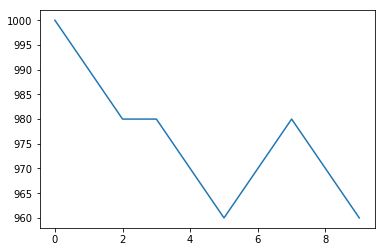

In [5]:
plt.plot(env.bankrolls[:5000])[0]
plt.show()

In [6]:
print(env.bankrolls)

[1000, 990, 980, 980, 970, 960, 970, 980, 970, 960]


In [7]:
env.player.bankroll


960